# RadarCOVID-Report

In [1]:
import matplotlib
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

## COVID-19 Cases

In [3]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")
confirmed_df = confirmed_df[confirmed_df["Country_EN"] == "Spain"]
confirmed_df = confirmed_df[pd.isna(confirmed_df["Region"])]
confirmed_df.drop(columns=["Country_EN", "Country_ES", "Country_IT", "Region"], inplace=True)
confirmed_df = confirmed_df.transpose()
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.head()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-01-23,0.0,NaN,NaN
1,2020-01-24,0.0,0.0,NaN
2,2020-01-25,0.0,0.0,NaN
3,2020-01-26,0.0,0.0,NaN
4,2020-01-27,0.0,0.0,NaN


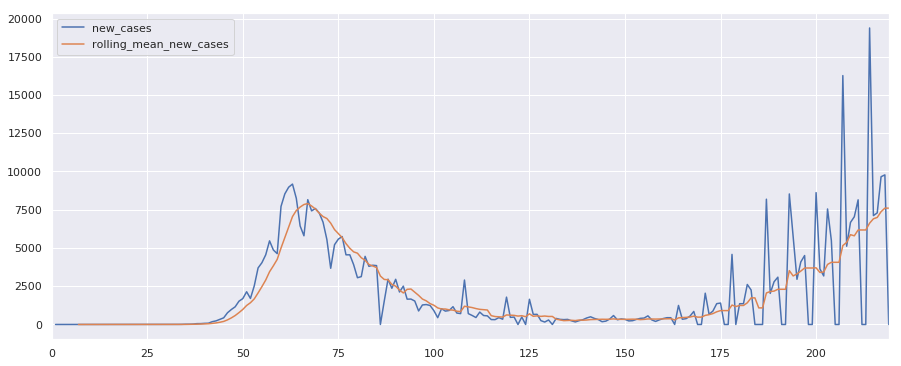

In [4]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

## RadarCOVID TEKs Extraction

In [5]:
from Modules.RadarCOVID import radar_covid

exposure_keys_df = radar_covid.download_last_radar_covid_exposure_keys(days=14)
exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]].head()

,sample_date_string,source_url,region,key_data
0,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,757936ab-531c-4872-1d83-ce7a8d135211
1,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,51d5fc97-3caf-8410-8fa2-f25f48547962
2,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,c314cde8-5365-8949-88e7-7ed2d1602fef
3,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,64531b2a-2054-c820-39e2-20fa21283d2c
4,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,e91b1672-ca72-87d7-099e-782e945728b0


In [6]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
exposure_keys_summary_df.head()

,tek_count
sample_date_string,
2020-08-28,27
2020-08-27,53
2020-08-26,66
2020-08-25,56
2020-08-24,48


In [7]:
exposure_keys_summary_df = exposure_keys_summary_df.merge(confirmed_df, on=["sample_date_string"], how="inner")
exposure_keys_summary_df["tek_count_per_new_case"] = \
    exposure_keys_summary_df.tek_count / exposure_keys_summary_df.rolling_mean_new_cases
exposure_keys_summary_df.head()

,sample_date_string,tek_count,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_new_case
0,2020-08-28,27,439286.0,9779.0,7604.571429,0.003550
1,2020-08-27,53,429507.0,9658.0,7371.571429,0.007190
2,2020-08-26,66,419849.0,7296.0,6997.428571,0.009432
3,2020-08-25,56,412553.0,7117.0,6908.142857,0.008106
4,2020-08-24,48,405436.0,19382.0,6622.000000,0.007249


In [8]:
exposure_keys_summary_df["sample_date"] = pd.to_datetime(exposure_keys_summary_df.sample_date_string)
exposure_keys_summary_df.set_index("sample_date", inplace=True)

## RadarCOVID TEKs Dump

In [9]:
import datetime

tek_list_df = exposure_keys_df[["sample_date_string", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    "sample_date").tek_list.unique().reset_index()
tek_list_df.to_json(
    "Data/RadarCOVID-Report-" + datetime.datetime.utcnow().strftime("%Y-%m-%d") + ".json",
    lines=True, orient="records")
tek_list_df

,sample_date,tek_list
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc]
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3..."
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69..."
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da..."
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0..."
5,2020-08-24,"[b040f48d-d3f9-6518-2b3d-24037d185437, bbc28f7..."
6,2020-08-25,"[88699284-d221-d821-76a9-6cd7b79f869c, 8ee3c02..."
7,2020-08-26,"[9ab2c4e3-d548-15b0-4c69-ac2087f2e7ef, 6bda721..."
8,2020-08-27,"[6e8eb4ae-d7cc-2dfe-9709-58c6de6aa724, 62d0ecb..."
9,2020-08-28,"[757936ab-531c-4872-1d83-ce7a8d135211, 51d5fc9..."


## Results

In [10]:
exposure_keys_summary_df[[
    "tek_count",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_new_case"]]

,tek_count,new_cases,rolling_mean_new_cases,tek_count_per_new_case
sample_date,,,,
2020-08-28,27,9779.0,7604.571429,0.003550
2020-08-27,53,9658.0,7371.571429,0.007190
2020-08-26,66,7296.0,6997.428571,0.009432
2020-08-25,56,7117.0,6908.142857,0.008106
2020-08-24,48,19382.0,6622.000000,0.007249
2020-08-23,28,0.0,6177.285714,0.004533
2020-08-22,18,0.0,6177.285714,0.002914
2020-08-21,11,8148.0,6177.285714,0.001781
2020-08-20,4,7039.0,5796.000000,0.000690


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f54354c4fa0>,
      dtype=object)

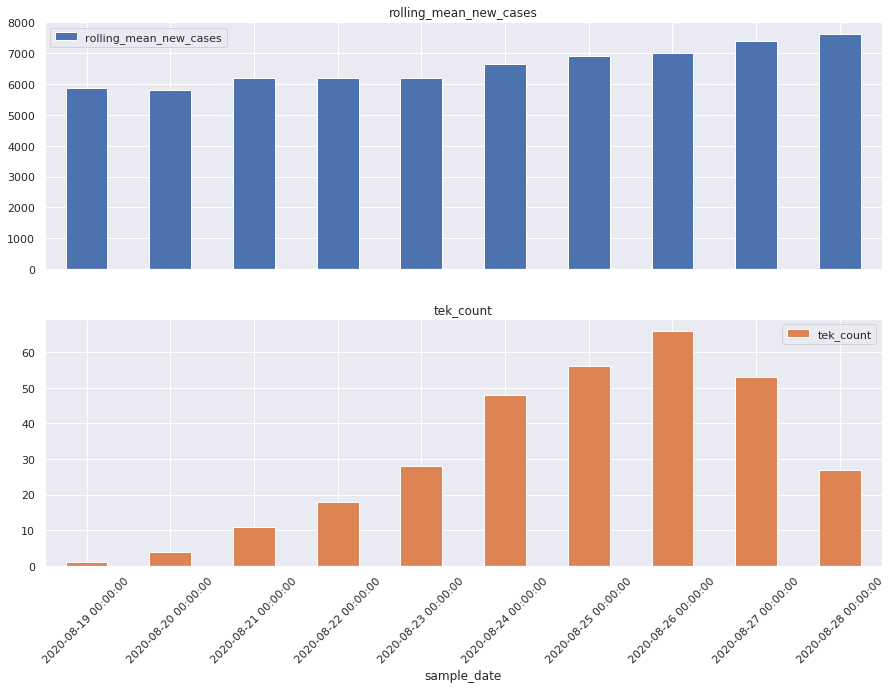

In [11]:
exposure_keys_summary_df[
    ["rolling_mean_new_cases", "tek_count"]].sort_index(ascending=True).plot.bar(
    rot=45, subplots=True, figsize=(15, 10))